<h1>Backpack Prediction Challenge</h>
<h4>Kaggle playground series, february 2025</h4>

<p><b>About the Tabular Playground Series</b></p>
<p>
"The goal of the Tabular Playground Series is to provide the Kaggle community with a variety of fairly light-weight challenges that can be used to learn and sharpen skills in different aspects of machine learning and data science. The duration of each competition will generally only last a few weeks, and may have longer or shorter durations depending on the challenge. The challenges will generally use fairly light-weight datasets that are synthetically generated from real-world data, and will provide an opportunity to quickly iterate through various model and feature engineering ideas, create visualizations, etc."</p>

[Walter Reade and Elizabeth Park. Backpack Prediction Challenge. https://kaggle.com/competitions/playground-series-s5e2, 2025. Kaggle.]

The task: Predict the price of backpacks based on various attributes.

Submissions are evaluated using Root Mean Squared Error (RMSE)


<b>What is the purpose of this notebook?</b>

This is the first competition I am participating in. My main goal here is to gain practical experience and learn the principles of data science with hands on examples. I am happy to learn and grow in this amazing community and I am thankful for any feedback. 
So let's get started :) 

## Table of Contents
- [EDA](#exploratory-data-analysis)
- [Preprocessing](#preprocessing)
- [Training and Evaluation](#training-and-evaluation)
- [Alternative Approach](#alternative-approach-:-target-encode-the-weight-capacity)
- [Conclusion](#conclusion)


## Exploratory Data Analysis

Special thanks to Tarun Mishra (<a href="https://www.kaggle.com/tarundirector">@tarundirector</a>) for providing a comprehensive guide for the EDA in this challenge. The following EDA is based on his <a href="https://www.kaggle.com/code/tarundirector/backpack-pred-baseline-ensemble-eda">notebook</a> 

### Getting familiar with the dataset

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
train_data = pd.read_csv("../dataset/train.csv")
test_data = pd.read_csv("../dataset/test.csv")
train_extra = pd.read_csv("../dataset/training_extra.csv")
train_data = pd.concat([train_data, train_extra] , ignore_index=True ,axis=0)

In [3]:
train_data.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [4]:
test_data.head()    

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
0,300000,Puma,Leather,Small,2.0,No,No,Tote,Green,20.671147
1,300001,Nike,Canvas,Medium,7.0,No,Yes,Backpack,Green,13.564105
2,300002,Adidas,Canvas,Large,9.0,No,Yes,Messenger,Blue,11.809799
3,300003,Adidas,Nylon,Large,1.0,Yes,No,Messenger,Green,18.477036
4,300004,NaN,Nylon,Large,2.0,Yes,Yes,Tote,Black,9.907953


How much data do we have?

In [5]:
train_data.shape

(3994318, 11)

-> 3994318 rows, 11 columns

In [6]:
test_data.shape

(200000, 10)

-> 200000 rows, 10 columns (price column is missing-> this is what we want to predict)

Are there missing values ?

In [7]:
train_missing_values = pd.DataFrame({"feature" : train_data.columns, 
                                     "missing values": train_data.isnull().sum().values,
                                     "percentage of missing values (%)": train_data.isnull().sum().values/ len(train_data)*100 })
train_missing_values

,feature,missing values,percentage of missing values (%)
0,id,0,0.000000
1,Brand,126758,3.173458
2,Material,110962,2.777996
3,Size,87785,2.197747
4,Compartments,0,0.000000
5,Laptop Compartment,98533,2.466829
6,Waterproof,94324,2.361454
7,Style,104180,2.608205
8,Color,133617,3.345177
9,Weight Capacity (kg),1808,0.045264


--> Missing values must be handled !

What data types do we have ? 

In [8]:
train_unique_values = pd.DataFrame({'feature': train_data.columns,
                              'no. of unique values': train_data.nunique().values})
train_unique_values

,feature,no. of unique values
0,id,3994318
1,Brand,5
2,Material,4
3,Size,3
4,Compartments,10
5,Laptop Compartment,2
6,Waterproof,2
7,Style,3
8,Color,6
9,Weight Capacity (kg),1920345


In [9]:
train_feature_types = pd.DataFrame({'feature': train_data.columns,
                              'dataType': train_data.dtypes})

train_feature_types

,feature,dataType
id,id,int64
Brand,Brand,object
Material,Material,object
Size,Size,object
Compartments,Compartments,float64
Laptop Compartment,Laptop Compartment,object
Waterproof,Waterproof,object
Style,Style,object
Color,Color,object
Weight Capacity (kg),Weight Capacity (kg),float64


3 numerical features, 9 categorical features
> Compartments is numerical but can also be handled as categorical (only 10 unique values)

> Target is numerical

Are there duplicates in the dataset ? 

In [10]:
test_duplicates = test_data.duplicated().sum()
train_duplicates = train_data.duplicated().sum()
print("Number of duplicates in test data: ", test_duplicates)
print("Number of duplicates in train data: ", train_duplicates)

Number of duplicates in test data:  0
Number of duplicates in train data:  0


In [11]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3994318.0,2.182137e+06,1.178058e+06,0.0,1.198579e+06,2.197158e+06,3.195738e+06,4194317.0
Compartments,3994318.0,5.434740e+00,2.893043e+00,1.0,3.000000e+00,5.000000e+00,8.000000e+00,10.0
Weight Capacity (kg),3992510.0,1.801042e+01,6.973969e+00,5.0,1.206896e+01,1.805436e+01,2.398751e+01,30.0
Price,3994318.0,8.136217e+01,3.893868e+01,15.0,4.747002e+01,8.098495e+01,1.148550e+02,150.0


**Features with wide distribution**:

> Weight Capacity: Mean 18, Min 5, Max 39

> Price: Mean 81, Min 15, max 150

--> Feature scaling may be needed

### Numerical feature analysis

In [12]:
# Add 'Dataset' column to distinguish between train and test data
train_data['Dataset'] = 'Train'
test_data['Dataset'] = 'Test'

# Weight Capacity is the only numercial feature we have
column = "Weight Capacity (kg)"
data_concat = pd.concat([train_data, test_data],ignore_index=True)

<Axes: xlabel='Weight Capacity (kg)', ylabel='Dataset'>

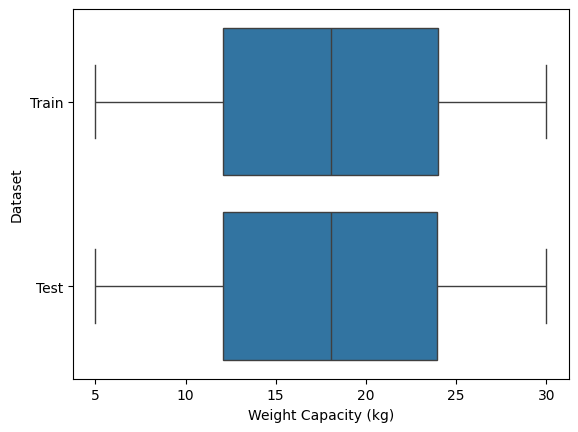

In [13]:
sns.boxplot(data=data_concat, x=column, y='Dataset')

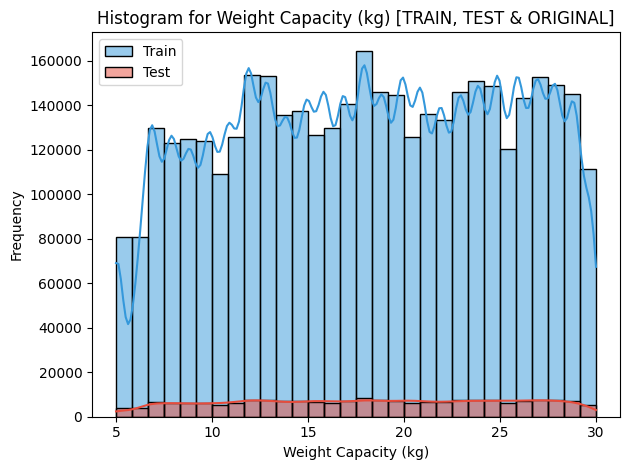

In [14]:
custom_palette = ['#3498db', '#e74c3c','#2ecc71']
sns.histplot(data=train_data, x=column, color=custom_palette[0], kde=True, bins=30, label="Train")
sns.histplot(data=test_data, x=column, color=custom_palette[1], kde=True, bins=30, label="Test")
plt.xlabel(column)
plt.ylabel("Frequency")
plt.title(f"Histogram for {column} [TRAIN, TEST & ORIGINAL]")
plt.legend()
plt.tight_layout()

In [15]:
train_data.drop('Dataset', axis=1, inplace=True)
test_data.drop('Dataset', axis=1, inplace=True)

### Categorical Feature Analysis

In [16]:
categorical_variables = ['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment','Waterproof', 'Style', 'Color']
pie_chart_palette = ['#33638d', '#28ae80', '#d3eb0c', '#ff9a0b', '#7e03a8', '#35b779', '#fde725', '#440154', '#90d743', '#482173', '#22a884', '#f8961e']

countplot_color = '#5C67A3'

In [17]:
def create_categorical_plots(variable):
    sns.set_style('whitegrid')
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Pie Chart TRAIN
    plt.subplot(1, 3, 1)
    train_data[variable].value_counts().plot.pie(
        autopct='%1.1f%%', colors=pie_chart_palette, wedgeprops=dict(width=0.3), startangle=140
    )
    plt.title(f"Pie Chart for {variable} [TRAIN]")

    # Pie Chart TEST
    plt.subplot(1, 3, 2)
    test_data[variable].value_counts().plot.pie(
        autopct='%1.1f%%', colors=pie_chart_palette, wedgeprops=dict(width=0.3), startangle=140
    )
    plt.title(f"Pie Chart for {variable} [TEST]")

    # Bar Graph
    plt.subplot(1, 3, 3)
    sns.countplot(
        data=pd.concat([train_data, test_data],ignore_index=True), 
        x=variable, 
        color=countplot_color,  # Using a single color for the countplot
        alpha=0.8  # Setting 80% opacity
    )
    plt.xlabel(variable)
    plt.ylabel("Count")
    plt.title(f"Bar Graph for {variable} [TRAIN, TEST Combined]")

    # Adjust spacing between subplots
    plt.tight_layout()
    
    # Show the plots
    plt.show()

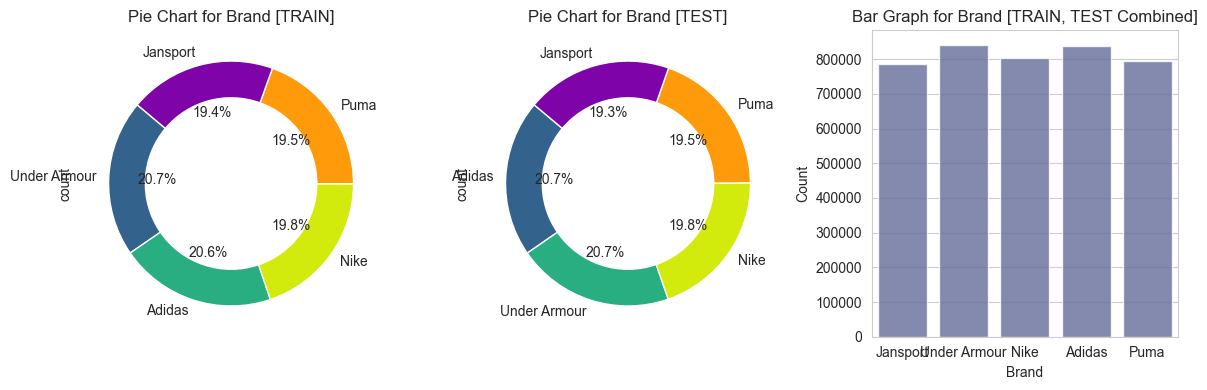

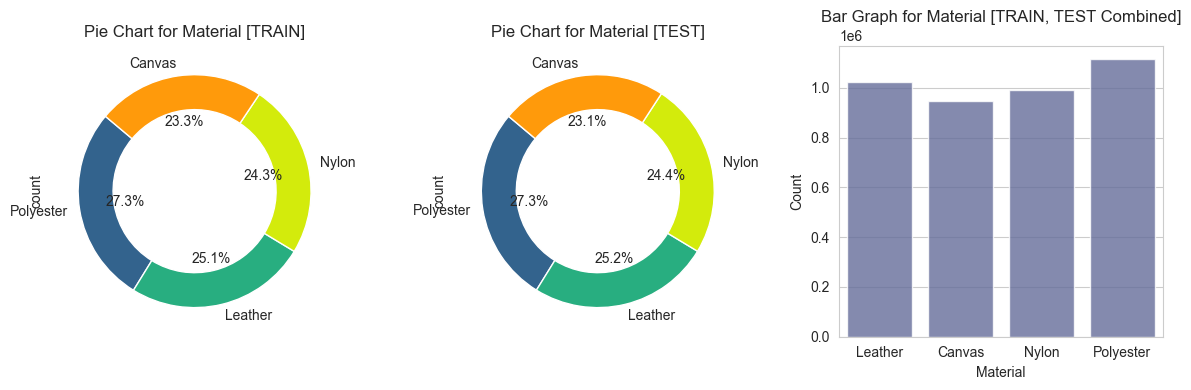

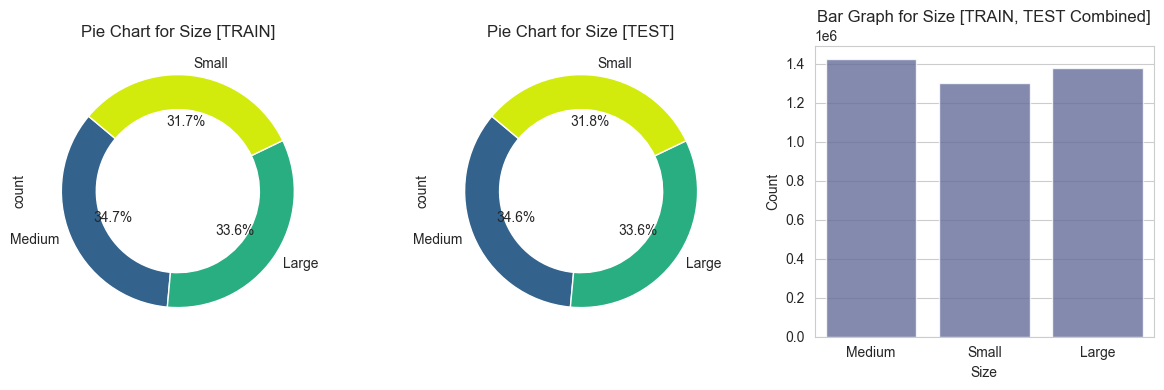

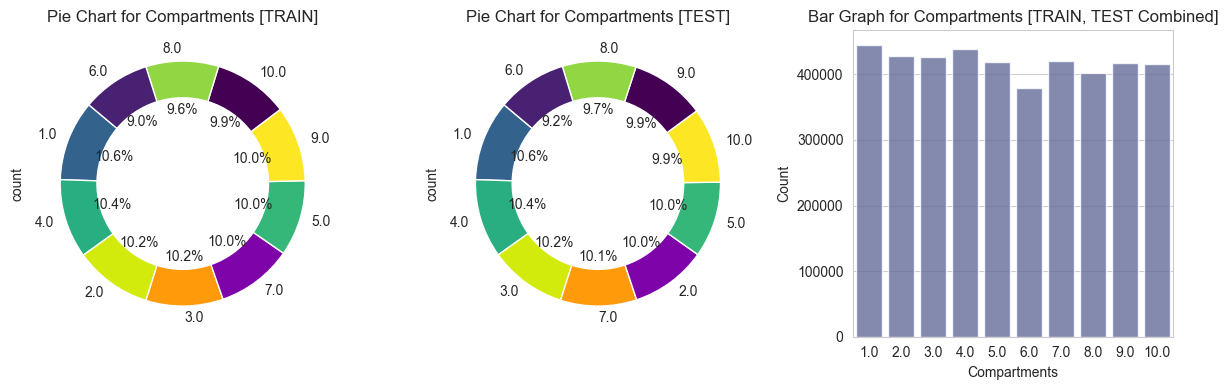

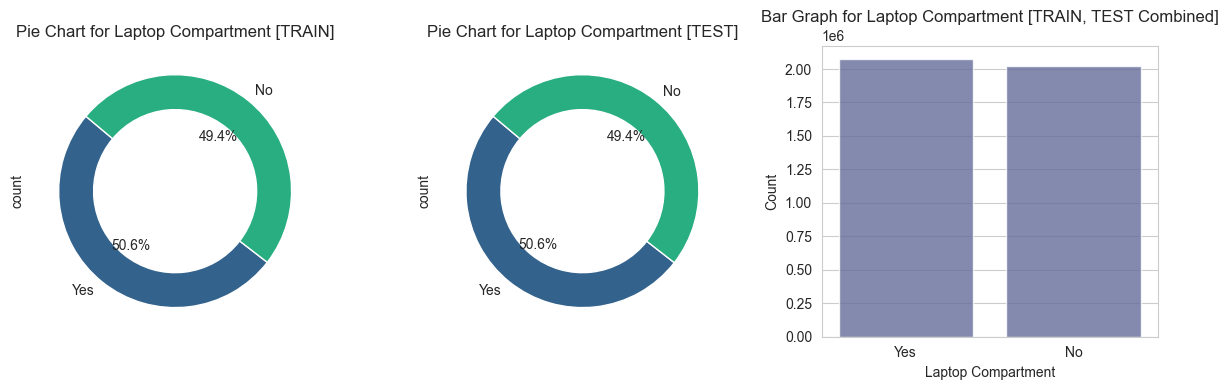

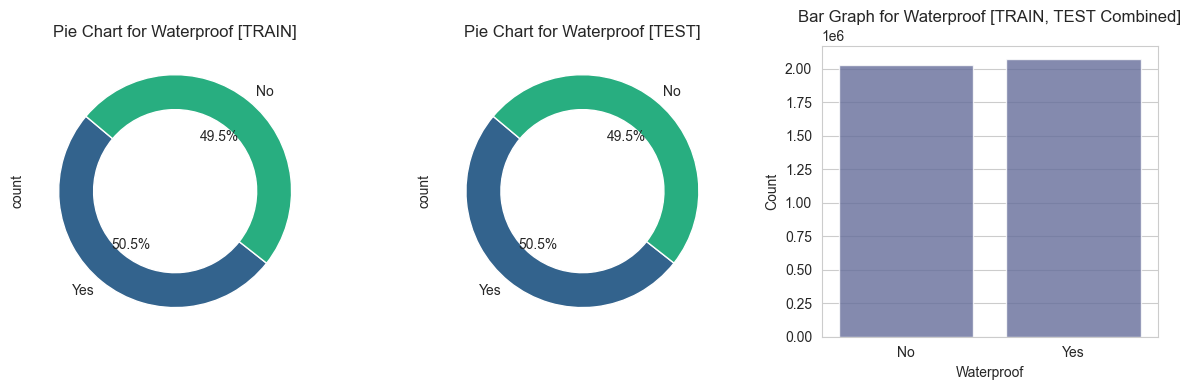

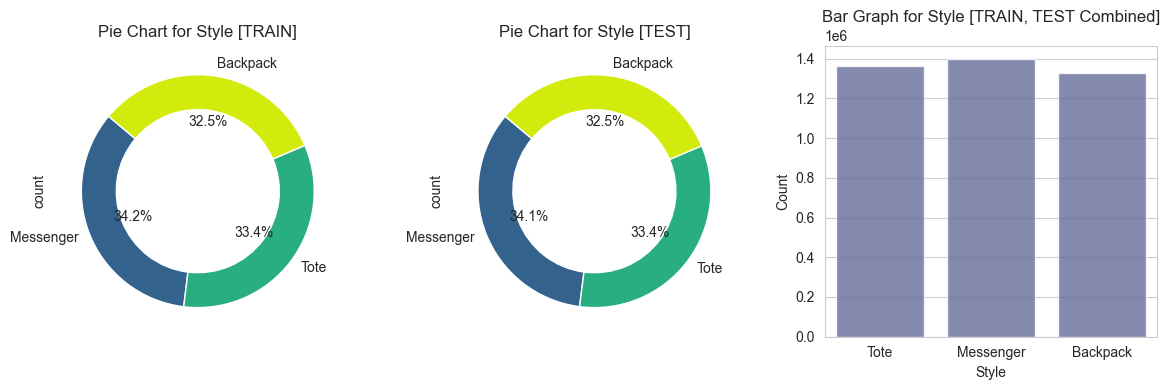

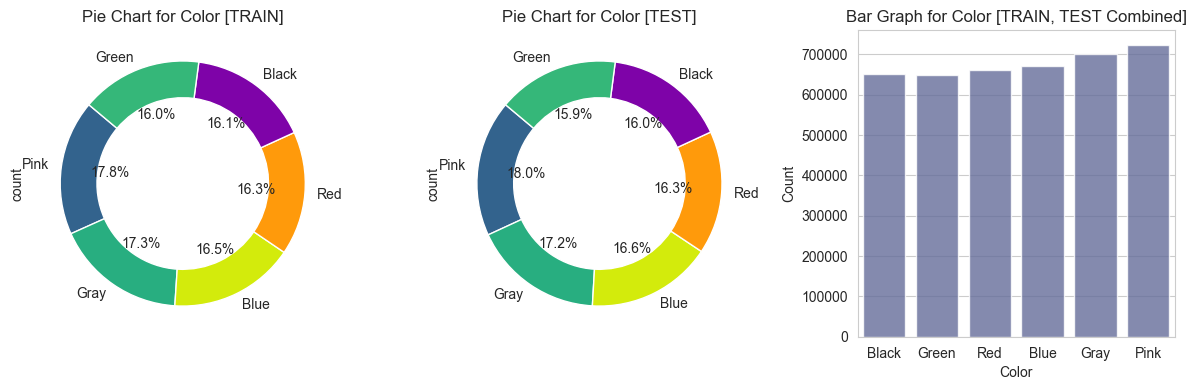

In [18]:
for variable in categorical_variables:
    create_categorical_plots(variable)

### Target Feature Analysis

In [19]:
target_palette = ['#3498db', '#e74c3c']
train_data['Dataset'] = 'Train'

C:\Users\engconstanti\AppData\Local\Temp\ipykernel_22904\3403798115.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_data, x=target_variable, y="Dataset", palette=target_palette)
C:\Users\engconstanti\AppData\Local\Temp\ipykernel_22904\3403798115.py:8: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=train_data, x=target_variable, y="Dataset", palette=target_palette)


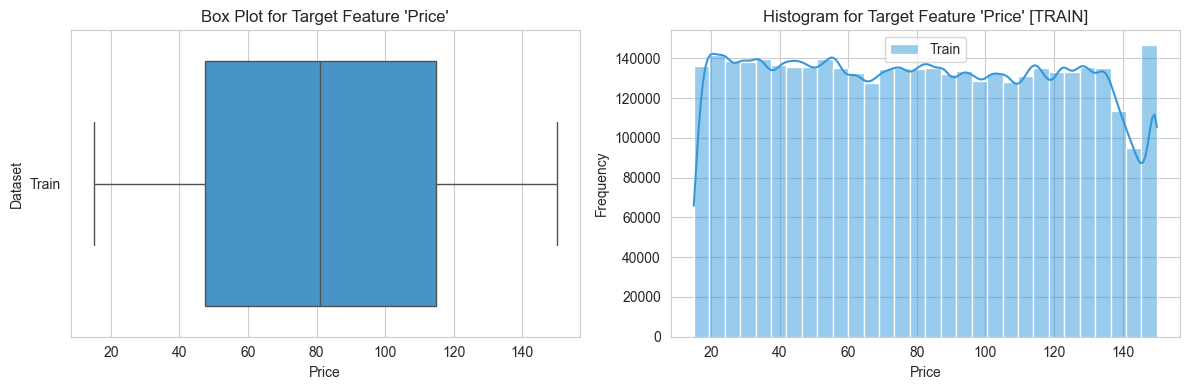

In [20]:
sns.set_style('whitegrid')
    
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
target_variable = "Price"

# Box Plot
plt.subplot(1, 2, 1)
sns.boxplot(data=train_data, x=target_variable, y="Dataset", palette=target_palette)
plt.xlabel(target_variable)
plt.title(f"Box Plot for Target Feature '{target_variable}'")

# Histogram
plt.subplot(1, 2, 2)
sns.histplot(data=train_data, x=target_variable, color=target_palette[0], kde=True, bins=30, label="Train")
plt.xlabel(target_variable)
plt.ylabel("Frequency")
plt.title(f"Histogram for Target Feature '{target_variable}' [TRAIN]")
plt.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()
train_data.drop('Dataset', axis=1, inplace=True)

### Bivariate Analysis

<Axes: >

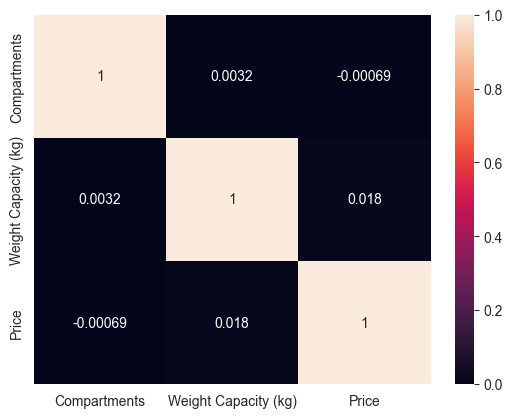

In [21]:

numerical_variables = ['Compartments','Weight Capacity (kg)', 'Price']
sns.heatmap(train_data[numerical_variables].corr(), annot=True)

> No significant correlation between numerical features are noticeable in this initial analysis

## Preprocessing

### Handling of missing values

As seen in the EDA, there are some missing values we should handle before continuing. 
For Categorical features we fill in the gaps with most frequent values of the respective columns. 
For the numerical feature "weight capacity" we fill the gaps using the median of all values.

In [22]:
categorical_features = ["Brand", "Material", "Size", "Laptop Compartment", "Waterproof", "Style", "Color"]
numerical_features = ["Weight Capacity (kg)"]

for col in categorical_features:
    train_data.fillna({col : train_data[col].mode()[0]}, inplace=True)
    test_data.fillna({col : test_data[col].mode()[0]}, inplace=True)

for col in numerical_features:
    train_data.fillna({col : train_data[col].median()}, inplace=True)
    test_data.fillna({col : test_data[col].median()}, inplace=True)

Also we drop the id column because we have no use for it:

In [23]:
train_data = train_data.drop("id", axis=1)
test_data_ids = test_data["id"]
test_data = test_data.drop("id", axis=1)  

### Handling of outliers

We use outlier detection using IQR ( Interquartile range)

"Detecting Outlier with IQR
IQR is used to measure variability by dividing a data set into quartiles. The data is sorted in ascending order and then we split it into 4 equal parts. The values Q1 (25th percentile), Q2 (50th percentile or median) and Q3 (75th percentile) separate dataset in 4 equal parts.

If a dataset has 2n or 2n+1 data points, then

Q2 = median of the dataset.

Q1 = median of n smallest data points.

Q3 = median of n highest data points.

The IQR is calculated as: IQR=Q3−Q1 = Q3 – Q1

Data points that fall below Q1−1.5×IQR or above Q3+1.5×IQR are considered outliers."
[https://www.geeksforgeeks.org/interquartile-range-to-detect-outliers-in-data/]

In [ ]:
column = "Weight Capacity (kg)"
Q1 = train_data[column].quantile(0.1)
Q3 = train_data[column].quantile(0.9)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_data = train_data[(train_data[column] >= lower_bound) & (train_data[column] <= upper_bound)]
no_of_outliers = len(train_data) - len(filtered_data)
print(f"Number of outliers in {column}: {no_of_outliers}")

Number of outliers in Weight Capacity (kg): 0


> No outliers detected

### Handling of Skewness

In [25]:
numerical_variables = ['Weight Capacity (kg)']

skewed_features = test_data[numerical_variables].skew()[test_data[numerical_variables].skew() > 0.75].index.values
print("Features with skewness > 0.75 in test_data:")
display(len(skewed_features))

skewed_features = train_data[numerical_variables].skew()[train_data[numerical_variables].skew() > 0.75].index.values
print("Features with skewness > 0.75 in train_data:")
display(len(skewed_features))

Features with skewness > 0.75 in test_data:


0

Features with skewness > 0.75 in train_data:


0

> Nothing to do here

### Feature encoding

For starters, we use pd.get_dummies to convert categorical values into numbers using one hot encoding. For later, it might be worth trying other options for feature encoding, such as target encoding. 

In [26]:
train_data.head()

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [27]:
columns_to_encode = ['Brand', 'Material', 'Size', 'Laptop Compartment','Waterproof', 'Style', 'Color']
train_data_to_encode = train_data[columns_to_encode]
test_data_to_encode = test_data[columns_to_encode]
train_data_encoded = pd.get_dummies(train_data_to_encode, columns=columns_to_encode, drop_first=True)
test_data_encoded = pd.get_dummies(test_data_to_encode, columns=columns_to_encode, drop_first=True)

In [28]:
train_data_encoded.head()

,Brand_Jansport,Brand_Nike,Brand_Puma,Brand_Under Armour,Material_Leather,Material_Nylon,Material_Polyester,Size_Medium,Size_Small,Laptop Compartment_Yes,Waterproof_Yes,Style_Messenger,Style_Tote,Color_Blue,Color_Gray,Color_Green,Color_Pink,Color_Red
0,True,False,False,False,True,False,False,True,False,True,False,False,True,False,False,False,False,False
1,True,False,False,False,False,False,False,False,True,True,True,True,False,False,False,True,False,False
2,False,False,False,True,True,False,False,False,True,True,False,True,False,False,False,False,False,True
3,False,True,False,False,False,True,False,False,True,True,False,True,False,False,False,True,False,False
4,False,False,False,False,False,False,False,True,False,True,True,True,False,False,False,True,False,False


### Scaling 

We use sklearn MinMaxScaler for scaling the numerical features

In [29]:
from sklearn.preprocessing import MinMaxScaler

train_data_to_scale = train_data.drop(columns_to_encode, axis=1)
test_data_to_scale = test_data.drop(columns_to_encode, axis=1)

minmax_scaler = MinMaxScaler()
minmax_scaler.fit(train_data_to_scale.drop(["Price"],axis=1))

MinMaxScaler()

In [30]:
train_data_scaled = minmax_scaler.transform(train_data_to_scale.drop(["Price"], axis=1))
scaled_train_df = pd.DataFrame(train_data_scaled, columns=train_data_to_scale.drop(['Price'], axis=1).columns)
test_data_scaled = minmax_scaler.transform(test_data_to_scale)
scaled_test_df = pd.DataFrame(test_data_scaled, columns=test_data_to_scale.columns)

# Concatenate train datasets
train_data_combined = pd.concat([train_data_encoded.reset_index(drop=True), scaled_train_df.reset_index(drop=True)], axis=1)
# Concatenate test datasets
test_data_combined = pd.concat([test_data_encoded.reset_index(drop=True), scaled_test_df.reset_index(drop=True)], axis=1)

Preprocessing is done for now. This is the resulting data, ready for model building: 

In [31]:
X = train_data_combined
y = train_data['Price']

In [32]:
X.head()

,Brand_Jansport,Brand_Nike,Brand_Puma,Brand_Under Armour,Material_Leather,Material_Nylon,Material_Polyester,Size_Medium,Size_Small,Laptop Compartment_Yes,Waterproof_Yes,Style_Messenger,Style_Tote,Color_Blue,Color_Gray,Color_Green,Color_Pink,Color_Red,Compartments,Weight Capacity (kg)
0,True,False,False,False,True,False,False,True,False,True,False,False,True,False,False,False,False,False,0.666667,0.264469
1,True,False,False,False,False,False,False,False,True,True,True,True,False,False,False,True,False,False,1.000000,0.883141
2,False,False,False,True,True,False,False,False,True,True,False,True,False,False,False,False,False,True,0.111111,0.465750
3,False,True,False,False,False,True,False,False,True,True,False,True,False,False,False,True,False,False,0.777778,0.317489
4,False,False,False,False,False,False,False,True,False,True,True,True,False,False,False,True,False,False,0.000000,0.509974


In [33]:
y.head()

0    112.15875
1     68.88056
2     39.17320
3     80.60793
4     86.02312
Name: Price, dtype: float64

## Training and Evaluation

### Baseline

First we want to create a simple baseline, to have something to compare the accuracy of our models to. For this we just calculate the mean price and make a submission with the mean price as the prediction for all backpacks

In [34]:
train_mean = train_data.Price.mean()
train_data['pred'] = train_mean
s = np.sqrt(np.mean((train_data.Price-train_data.pred)**2.0 ) )
print(f"RMSE using Train Mean = {s}")

RMSE using Train Mean = 38.93867923358144


In [35]:
sub = pd.read_csv("../dataset/sample_submission.csv")
sub['Price'] = train_mean
sub.to_csv("submission_mean.csv", index=False)

This gives us a RMSE of 39.16 on the leaderboard

### Ensemble with feature importance

For the first approach we use an ensemble of Random Forest, xgboost and lightgbm. Thanks to Tarun Mishra (<a href="https://www.kaggle.com/tarundirector">@tarundirector</a>) for providing a well documented example of the ensemble approach for this challenge

In [36]:
# split into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.1, objective='reg:squarederror', random_state=42)
lgb_model = lgb.LGBMRegressor(n_estimators=300, learning_rate=0.1, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42, max_depth=10)

print("Training XGBoost...")
xgb_model.fit(X_train, y_train)
print("Training LightGBM...")
lgb_model.fit(X_train, y_train)
print("Training RandomForest...")
rf_model.fit(X_train, y_train)

# Predict on validation sets
val_preds_xgb = xgb_model.predict(X_val)
val_preds_lgb = lgb_model.predict(X_val)
val_preds_rf = rf_model.predict(X_val)

Training XGBoost...
Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 301
[LightGBM] [Info] Number of data points in the train set: 3195454, number of used features: 20
[LightGBM] [Info] Start training from score 81.361311
Training RandomForest...


Now let's evaluate the metrics of our models

In [38]:
def calculateMetrics(Y_val, val_preds_lgb, val_preds_xgb,val_preds_rf):
    # Calculate metrics for each model
    mse_xgb = mean_squared_error(Y_val, val_preds_xgb)
    mse_lgb = mean_squared_error(Y_val, val_preds_lgb)
    mse_rf = mean_squared_error(Y_val, val_preds_rf)

    mae_xgb = mean_absolute_error(Y_val, val_preds_xgb)
    mae_lgb = mean_absolute_error(Y_val, val_preds_lgb)
    mae_rf = mean_absolute_error(Y_val, val_preds_rf)

    rmse_xgb = mse_xgb ** 0.5
    rmse_lgb = mse_lgb ** 0.5
    rmse_rf = mse_rf ** 0.5

    r2_xgb = r2_score(Y_val, val_preds_xgb)
    r2_lgb = r2_score(Y_val, val_preds_lgb)
    r2_rf = r2_score(Y_val, val_preds_rf)

    # Print the metrics
    print("XGBoost Metrics:")
    print(f"MSE: {mse_xgb:.4f}, MAE: {mae_xgb:.4f}, RMSE: {rmse_xgb:.4f}, R2: {r2_xgb:.4f}")

    print("LightGBM Metrics:")
    print(f"MSE: {mse_lgb:.4f}, MAE: {mae_lgb:.4f}, RMSE: {rmse_lgb:.4f}, R2: {r2_lgb:.4f}")

    print("Random Forest Metrics:")
    print(f"MSE: {mse_rf:.4f}, MAE: {mae_rf:.4f}, RMSE: {rmse_rf:.4f}, R2: {r2_rf:.4f}")

calculateMetrics(y_val,val_preds_lgb, val_preds_xgb,val_preds_rf)

XGBoost Metrics:
MSE: 1511.9789, MAE: 33.6264, RMSE: 38.8842, R2: 0.0016
LightGBM Metrics:
MSE: 1511.5248, MAE: 33.6242, RMSE: 38.8783, R2: 0.0019
Random Forest Metrics:
MSE: 1511.9148, MAE: 33.6310, RMSE: 38.8833, R2: 0.0017


Let's see if adding feature importance helps

In [39]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'XGBoost': xgb_model.feature_importances_,
    'LightGBM': lgb_model.feature_importances_,
    'RandomForest': rf_model.feature_importances_
})

## normalize the feature importance table
minmax_scaler = MinMaxScaler()
minmax_scaler.fit(feature_importance.drop(["Feature"],axis=1))
normalized_feature_importance = minmax_scaler.transform(feature_importance.drop(["Feature"],axis=1))

normalized_feature_importance = pd.DataFrame(normalized_feature_importance, columns=feature_importance.drop(['Feature'], axis=1).columns)
normalized_feature_importance = pd.concat([feature_importance["Feature"].reset_index(drop=True), normalized_feature_importance.reset_index(drop=True)], axis=1)
normalized_feature_importance['Average_Importance'] = normalized_feature_importance.iloc[:, 1:].mean(axis=1)
normalized_feature_importance = normalized_feature_importance.sort_values(by='Average_Importance', ascending=False)

In [40]:
normalized_feature_importance

,Feature,XGBoost,LightGBM,RandomForest,Average_Importance
19,Weight Capacity (kg),0.552447,1.000000,1.000000,0.850816
4,Material_Leather,1.000000,0.045660,0.070676,0.372112
15,Color_Green,0.760614,0.013962,0.040736,0.271771
18,Compartments,0.137358,0.473585,0.178447,0.263130
13,Color_Blue,0.568070,0.013585,0.033305,0.204987
5,Material_Nylon,0.430210,0.033585,0.029750,0.164515
16,Color_Pink,0.444662,0.013962,0.023843,0.160823
0,Brand_Jansport,0.421515,0.036226,0.021947,0.159896
3,Brand_Under Armour,0.419027,0.025660,0.033927,0.159538
7,Size_Medium,0.168984,0.050943,0.020411,0.080113


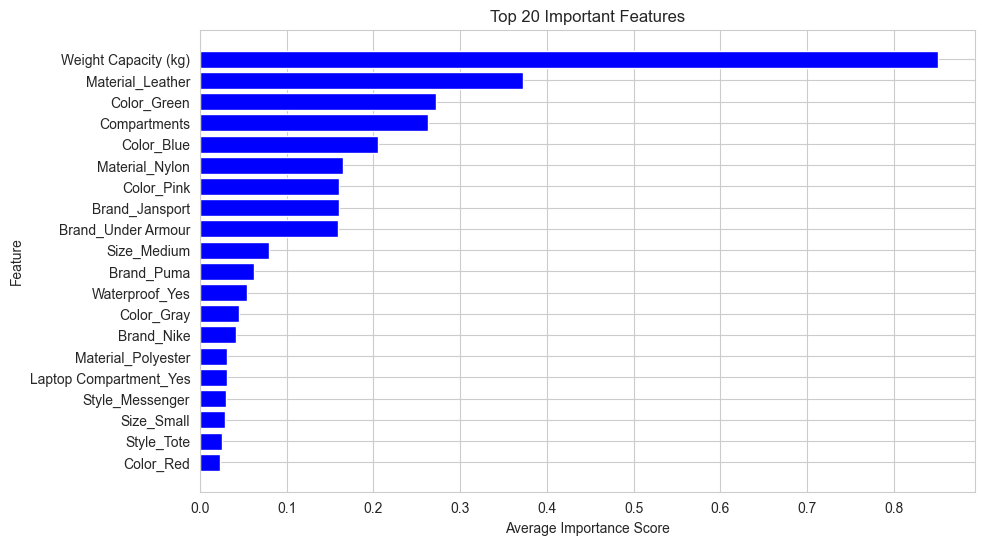

In [41]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(normalized_feature_importance['Feature'][:20], normalized_feature_importance['Average_Importance'][:20], color='blue')
plt.xlabel("Average Importance Score")
plt.ylabel("Feature")
plt.title("Top 20 Important Features")
plt.gca().invert_yaxis()
plt.show()

Now we get rid of the least important features (the worst 20%)

In [42]:
threshold = normalized_feature_importance['Average_Importance'].quantile(0.20)
selected_features = normalized_feature_importance[normalized_feature_importance['Average_Importance'] > threshold]['Feature'].tolist()

And retrain on those features

In [43]:
X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]
test_data_selected = test_data_combined[selected_features]

xgb_model.fit(X_train_selected, y_train)
lgb_model.fit(X_train_selected, y_train)
rf_model.fit(X_train_selected, y_train)

val_preds_xgb = xgb_model.predict(X_val_selected)
val_preds_lgb = lgb_model.predict(X_val_selected)
val_preds_rf = rf_model.predict(X_val_selected)

calculateMetrics(y_val, val_preds_xgb,val_preds_lgb,val_preds_rf)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 293
[LightGBM] [Info] Number of data points in the train set: 3195454, number of used features: 16
[LightGBM] [Info] Start training from score 81.361311
XGBoost Metrics:
MSE: 1511.6171, MAE: 33.6246, RMSE: 38.8795, R2: 0.0019
LightGBM Metrics:
MSE: 1512.0880, MAE: 33.6284, RMSE: 38.8856, R2: 0.0015
Random Forest Metrics:
MSE: 1511.8926, MAE: 33.6308, RMSE: 38.8831, R2: 0.0017


Now we optimize the weights of our ensemble

In [44]:
from scipy.optimize import minimize

def loss(weights):
    weighted_preds = (weights[0] * val_preds_xgb +
                      weights[1] * val_preds_lgb +
                      weights[2] * val_preds_rf)
    return mean_absolute_error(y_val, weighted_preds)

initial_weights = [0.33333, 0.33333, 0.33333]
constraints = ({'type': 'eq', 'fun': lambda w: 1 - sum(w)})
bounds = [(0, 1)] * 3

result = minimize(loss, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
optimal_weights = result.x


... and predict again, using the ensemble of models

In [45]:
val_preds = (optimal_weights[0] * val_preds_xgb +
             optimal_weights[1] * val_preds_lgb +
             optimal_weights[2] * val_preds_rf)

rmse = np.sqrt(np.mean((y_val-val_preds)**2.0 ) )

print(f"Optimized Validation RMSE: {rmse}")
print(f"Optimal Weights: {optimal_weights}")

Optimized Validation RMSE: 38.87714285456069
Optimal Weights: [0.32995534 0.3945578  0.27548686]


Now let's create a submission

In [46]:
test_preds_xgb = xgb_model.predict(test_data_selected)
test_preds_lgb = lgb_model.predict(test_data_selected)
test_preds_rf = rf_model.predict(test_data_selected)

test_preds = (optimal_weights[0] * test_preds_xgb +
              optimal_weights[1] * test_preds_lgb +
              optimal_weights[2] * test_preds_rf)

ensemble_submission_df = pd.DataFrame({
    'id': test_data_ids,
    'Price': test_preds
})

ensemble_submission_df.to_csv('submission_ensemble_with_feature_importance.csv', index=False)
ensemble_submission_df.head(10)

,id,Price
0,300000,80.350649
1,300001,82.256888
2,300002,82.743818
3,300003,81.522598
4,300004,78.733803
5,300005,82.193661
6,300006,81.729722
7,300007,83.955176
8,300008,81.928634
9,300009,78.945973


The submission scores a 39.12 RMSE on the leaderboard, which is a slight improvement to the baseline

After some more experiments and parameter tuning, I wasn't able to improve the model further.   
There seems to be little to no signal in the categorical features of the dataset.  
See this community <a href="https://www.kaggle.com/competitions/playground-series-s5e2/discussion/560669">thread</a> for more discussions about this.   
The signal seems to be mostly in the weight capacity feature and is probably due to the synthetic creation of the dataset.  
<a href="https://www.kaggle.com/cdeotte">@cdeotte</a> has pointed out some interesting approaches of targeting the signal of coming from synthetic data creation, explained in this <a href="https://www.kaggle.com/competitions/playground-series-s5e2/discussion/564056#3135174">discussion</a>  
For fun, let's try to recreate the target encoding approach using the weight capacity and binning feature of pandas: 

## Alternative Approach : Target encode the weight capacity

In [47]:
train = pd.read_csv("../dataset/train.csv")
train_extra = pd.read_csv("../dataset/training_extra.csv")
train = pd.concat([train,train_extra],axis=0,ignore_index=True)
train.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


Using pandas qcut function we create 65 bins for the weight capacity and then calculate the mean price for each bin

In [48]:
import pandas as pd
import numpy as np

# Create bins for the numerical variable
train['Weight Capacity Binned'] = pd.qcut(train['Weight Capacity (kg)'], q=65, labels=False)

# Calculate the mean price for each bin
mean_price = train.groupby('Weight Capacity Binned')['Price'].mean()
train['pred'] = train['Weight Capacity Binned'].map(mean_price)

# Calculate RMSE
s = np.sqrt(np.mean((train['Price'] - train['pred']) ** 2.0))
print(f"Validation RMSE using Target Encode Weight Capacity = {s}")

Validation RMSE using Target Encode Weight Capacity = 38.91638772527208


... and do the same for the test set

In [ ]:
test = pd.read_csv("../dataset/test.csv")
test['Weight Capacity Binned'] = pd.qcut(test['Weight Capacity (kg)'], q=65, labels=False)

Then we use the mean price of of the training set bins and apply it to the test set bins

In [50]:
test['Price'] = test['Weight Capacity Binned'].map(mean_price)
sub = pd.read_csv("../dataset/sample_submission.csv")
sub['Price'] = test['Price']
sub.fillna({"Price" : sub["Price"].median()}, inplace=True)
sub.to_csv("submission_TE_weight_capacity.csv", index=False)
sub.head()

,id,Price
0,300000,80.904859
1,300001,80.766641
2,300002,82.534394
3,300003,81.782256
4,300004,79.786098


This scores a 39.15 on the leaderboard and seems to be no improvement to the ensemble model

# Conclusion

I had much fun participating in my first kaggle competition, reading the threads and trying out different things. I am positive that I have learned a lot just from participating. I look forward to seeing the final results and participating in new competitions!

Thanks for reading :) 